In [1]:
%load_ext autoreload
%autoreload 2
import cmcrameri.cm as cm  # Importing the cmcrameri colormaps
%run ct_data.py '../crunchtope_model/results.nc' -c volume
%run pf_data.py '../pflotran_model/little_dev_model/chem_model.h5'

Primary minerals: ['Anorthite', 'Albite', 'Diopside', 'Hedenbergite', 'Forsterite', 'Fayalite']
Secondary minerals: ['Tremolite', 'Epidote', 'Zoisite', 'Chamosite-7A', 'Clinochlore-7A', 'Analcime', 'Anhydrite', 'Calcite']
Primary mineral groups: {'olivine': ['Forsterite', 'Fayalite'], 'clinopyroxenes': ['Diopside', 'Hedenbergite'], 'plagioclases': ['Anorthite', 'Albite']}
Secondary mineral groups: {'clays': ['Saponite_Mg', 'Chamosite-7A', 'Clinochlore-7A'], 'zeolites': ['Analcime'], 'amphiboles': ['Tremolite'], 'serpentinites': ['Talc'], 'epidotes': ['Epidote', 'Zoisite'], 'sulfates': ['Anhydrite'], 'carbonates': ['Calcite']}
Primary minerals: ['Anorthite', 'Albite', 'Diopside', 'Hedenbergite', 'Forsterite', 'Fayalite']
Secondary minerals: ['Tremolite', 'Talc', 'Quartz', 'Saponite_Mg', 'Epidote', 'Zoisite', 'Chamosite-7A', 'Clinochlore-7A', 'Analcime', 'Anhydrite', 'Calcite']
Primary mineral groups: {'olivine': ['Forsterite', 'Fayalite'], 'clinopyroxenes': ['Diopside', 'Hedenbergite'],

In [2]:
#Parameters
time = 1000
category = 'volume'
plot_vars = ['Anhydrite'] * 4

# Plot options
fontsize = 16

In [3]:
def plot_flux(ax, concentrations, data, range_sets, legend_entries, crunchtope=False):
    if crunchtope:
        dims = ['X', 'Y', 'Z']
    else:
        dims = ['x', 'y', 'z']
    for conc_range, range_set, legend_entry in zip(concentrations, range_sets, legend_entries):
        # Processing data
        extracted_data = data.sel(time=time).isel(file_num=slice(range_set[0], range_set[1] + 1)).sum(dim=dims)
        ax.plot(conc_range, extracted_data, label=legend_entry)

In [7]:

time=1000

def total_volume(data, mineral):
    # Sum variables over all coordinates and select the final time 
    total_vf = data.sum(dim=('x','y','z')).sel(time=time)[mineral].to_numpy()
    print(total_vf)
    total_volume = total_vf * 46.9 * 46.9 * 100 # m^3 

    return total_volume

def volume_to_moles(volume, molar_volume):
    moles = volume / molar_volume
    return moles

molar_volume = 46.01 * (0.01 ** 3) # cm3/mol

vol = total_volume(pf_data, "Anhydrite_VF")
moles = volume_to_moles(vol, molar_volume)
print(moles / time *65000e3 /100 /1e12)
#s_moles_to_flux(moles) / 100

[0.0980321 0.0980321 0.0980321 0.0980321 0.0980321 0.0980321 0.0980321
 0.0980321 0.0980321 0.0980321 0.0980321 0.0980321 0.0980321 0.0980321
 0.0980321 0.0980321 0.0980321 0.0980321 0.0980321 0.0980321 0.0980321
 0.0980321 0.0980321 0.0980321 0.0980321 0.0980321 0.0980321 0.0980321
 0.0980321]
[0.30463172 0.30463172 0.30463172 0.30463172 0.30463172 0.30463172
 0.30463172 0.30463172 0.30463172 0.30463172 0.30463172 0.30463172
 0.30463172 0.30463172 0.30463172 0.30463172 0.30463172 0.30463172
 0.30463172 0.30463172 0.30463172 0.30463172 0.30463172 0.30463172
 0.30463172 0.30463172 0.30463172 0.30463172 0.30463172]


/tmp/ipykernel_28905/1266855227.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


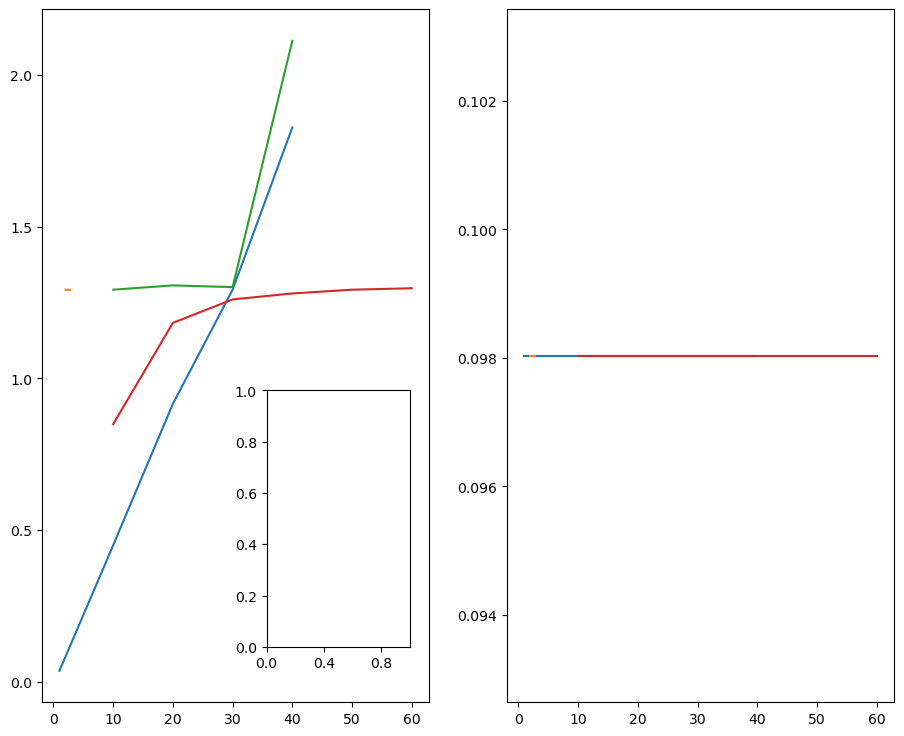

In [5]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from cmcrameri import cm
import numpy as np
import copy
import string

fig, ax = plt.subplots(1,2, figsize=(11,9))
ax = ax.flatten()

leg_entries = ['SO$\mathbf{_4^{2-}}$', 'HCO$\mathbf{_3^-}$', 'Ca$\mathbf{^{2+}}$', 'Mg$\mathbf{^{2+}}$']
scale_factors = (1,1,1,1)
range_sets = [(10,14), (15,19), (6,9), (0,5)]
concentrations = [[1 ,10, 20, 30, 40], # SO4
          [2.0, 2.2, 2.4, 2.6, 2.8], # HCO3
          [10, 20, 30, 40], # Ca
          [10, 20, 30, 40, 50, 60]] # Mg

#Cell vol /cm^3
cell_vol = 200 * 100**2
#Calcite molar volume cm^3/mol
anhyd_mv = 46.010
vf_to_mols = cell_vol / anhyd_mv

scale_factors = (vf_to_mols, vf_to_mols, vf_to_mols, vf_to_mols)

scaling = 'global'

## Format axis
#axins1 = axis.inset_axes([0.58, 0.08, 0.37, 0.37])
#axis.set_xlabel('Concentration / mM')
#if scaling == 'global':
#    axis.set_ylabel('Global S flux into Crust / Tmol yr$^{-1}$')
#    #axis.set_ylim(0.19,1)
#    #axis.set_ylim(0,1)
#    axis.set_xlim(0,65)
#    axins1.set_ylim(0.14,0.16)
#    axins1.set_xlim(1.9,2.9)

#axins1.xaxis.set_major_locator(plt.MaxNLocator(3))
#axins1.yaxis.set_major_locator(plt.MaxNLocator(5))

# MUST REMOVE, add some dummy data for PF
file_num_values = range(0,29)  # Example values for the new dimension
# Use expand_dims to add the new dimension
pf_data = pf_data.expand_dims({"file_num": file_num_values})

plot_flux(ax[0], concentrations, ct_data['volume']['Anhydrite'], range_sets, leg_entries, crunchtope=True)   
plot_flux(ax[1], concentrations, pf_data['Anhydrite_VF'], range_sets, leg_entries)   

#    iterables = zip(np.arange(len(plot_vars)), plot_vars, legend_titles, scale_factors, range_sets, labels, leg_entries, colours)
#    # Axis level loop
#    for j, plot_var, legend_title, scale, range_set, label_a, leg_entry, col in iterables:
#        # Line set loop (i.e. groups of lines sharing a property)
#        # Line instance loop
#        index = np.arange(range_set[0], range_set[1]+1)
#        y = []
#        x = copy.deepcopy(label_a)
#        pop_list = []
#
#        for n, ind in enumerate(index):
#            try:
#                val = dataset[category].isel(file_num = ind, time=time, Y=0, Z=0)[plot_var].sum(dim='X').to_numpy() * scale
#                if val == 0:
#                    pop_list.append(n)
#                else:
#                    y.append(val)
#            except:
#                pop_list.append(n)
#                continue
#                
#        print(y)
#
#        pop_list.sort(reverse=True)
#        for q in pop_list:
#            x.pop(q)
#
#        if j == 1:
#            if scaling == 'global':
#                axins1.plot(x, s_moles_to_flux(y), label=f'{leg_entry}', linestyle=ls, c=col, linewidth=7)
#            else:
#                axins1.plot(x, y, label=f'{leg_entry}', linestyle=ls, c=col, linewidth=7)
#            axis.plot(np.NaN, np.NaN, label=f'{leg_entry}', c=col, ls = ls, linewidth=7)
#        else:
#            if scaling == 'global':
#                axis.plot(x, s_moles_to_flux(y), label= f'{leg_entry}', linestyle=ls, c=col, linewidth=7)
#            else:
#                axis.plot(x, y, label= f'{leg_entry}', linestyle=ls, c=col, linewidth=7)
#        # Axis decorations
#        axis.legend(title='Seawater component', title_fontproperties=legend_props, prop=legend_props, fontsize=12, framealpha=0, loc=2)
#        fig.tight_layout()
#        fig.savefig(f'output/{j}_{temperature}.png', dpi=300)
#
#
#styles = ['-', '--']
#ax2 = axis.twinx()
#for sty, temp in zip(styles, temperatures):
#    ax2.plot(np.NaN, np.NaN, ls=sty,
#             label=temp, c='black')
#ax2.get_yaxis().set_visible(False)
#ax2.legend(title='Temperature / °C', prop=font_props, title_fontproperties=font_props, framealpha=0, loc=1)

fig.show()
fig.savefig('output/anhydrite_v_cations.png', dpi=300, transparent=True)

